## Introduction

When I was searching for approaches to handle imbalanced dataset, one potential solution I encountered is using focal loss as the loss function, which was initially proposed to resolve the imbalance issues for object detection problems. There has been attempts to apply this to LightGBM with some common pitfalls identified in [1]. Inspired by these work, my goal is to create a classifier that uses focal loss by default.

The obvious question is why couldn't we simply use `LGMClassifier`, the sklearn api for LightGBM, and directly set a custom objective function. Well, while it does offer the option to set `objective`, it has been found that implementing focal loss with LightGBM requires resetting initialization values [1], which essentially breaks down the model building process to several steps. What I'd like to have is a model class object that can be easily called like any other sklearn models. 

To this end, the notebook will start replicating the implementation as described in [1] and then 

In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from scipy import special
from sklearn import metrics


In [2]:
# load data
data = arff.loadarff('phpKo8OWT.arff')
df = pd.DataFrame(data[0])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,b'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,b'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,b'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,b'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,b'0'


In [3]:
# data processing
X = df.drop('Class', axis=1)
y = df['Class']
y = y.map({b'0': 0, b'1':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Logloss implementation

First let's try to write some functions for logloss so we can compare this with the custom .

In [4]:
from scipy import special
from sklearn import metrics

def logloss_init_score(y):
    p = y.mean()
    p = np.clip(p, 1e-15, 1 - 1e-15)
    log_odds = np.log(p / (1 - p))
    return log_odds

def logloss_objective(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    grad = p - y
    hess = p * (1 - p)
    return grad, hess

def logloss_metric(preds, train_data):
    y = train_data.get_label()
    p = special.expit(preds)
    is_higher_better = False
    return 'logloss', metrics.log_loss(y, p), is_higher_better

In [5]:
# train a lightgbm model with defaul loss function
# IMPORTANT NOTE: we need to set objective and learning rate explicitly so we can get the same result
params = {
    'objective': 'binary',
    'learning_rate': 0.01,
    'random_seed': 0 }

train_set = lgb.Dataset(data=X_train, label=y_train)
model = lgb.train(params=params, train_set=train_set, valid_sets=train_set)
y_pred = model.predict(X_test)
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")

[LightGBM] [Info] Number of positive: 379, number of negative: 213226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001774 -> initscore=-6.332572
[LightGBM] [Info] Start training from score -6.332572
Test ROC AUC: 0.97091
Test logloss 0.00327


In [6]:
# now train the lightgbm model with the custom logloss function
# we should expect the same result
params = {
        'learning_rate': 0.01,
          'random_seed': 0,
          'objective': logloss_objective
}
init_scores = np.full_like(y_train, logloss_init_score(y_train), dtype=float)
train_set = lgb.Dataset(data=X_train, label=y_train, init_score=init_scores)
model = lgb.train(params=params, train_set=train_set, feval=logloss_metric)
y_pred = special.expit(logloss_init_score(y_train)+model.predict(X_test))
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")


[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Info] Using self-defined objective function
Test ROC AUC: 0.97091
Test logloss 0.00327


In [7]:
# train the model using scikit-learn API 
# interestingly if we use LGBMClassifier, we have different results possibly due to other parameter setting. 

model = lgb.LGBMClassifier()
params = {"objective": 'binary', "learning_rate": 0.01, "random_seed": 0}
model.set_params(**params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")

[LightGBM] [Info] Number of positive: 379, number of negative: 213226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001774 -> initscore=-6.332572
[LightGBM] [Info] Start training from score -6.332572
Test ROC AUC: 0.84510
Test logloss 0.01974


## Focal loss implementation

Now let's use the model with focal loss implemented. There are two important parameters for the focal loss function defined as `obj_alpha` and `obj_gamma`. By default, they are set to 0 and None, which makes the focal loss equivalent to logloss. 

If we call the model with these settings, we can see the results are very similar to the naive LightGBM model. 

In [8]:
from models import CustomLGBMClassifier
from logger import CustomLogger
lgb.register_logger(CustomLogger())
model = CustomLGBMClassifier()
params = {
 'learning_rate': 0.01,
 'random_seed': 0
}
model.set_params(**params)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")

Test ROC AUC: 0.97084
Test logloss 0.00327


I also added other methods such as `set_params` to the model so that it can be used just like `LGBMClassifier` for things such as visualisation and hyper-parameter tuning.

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='focal_loss'>

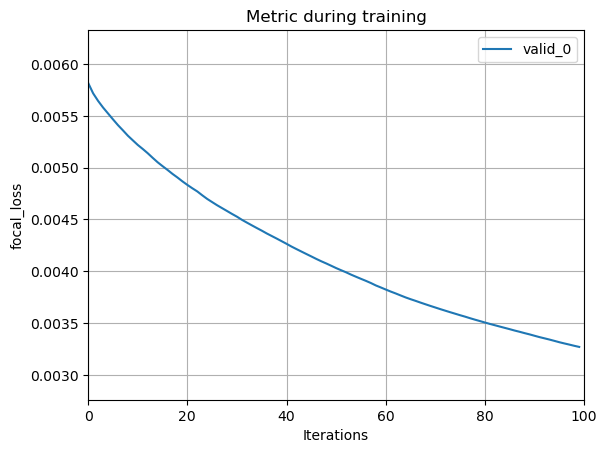

In [9]:
from lightgbm import plot_metric, plot_tree
model.fit(X_train, y_train, eval_set=(X_test, y_test))
plot_metric(model)

In [10]:
model = CustomLGBMClassifier()
params = {
          'early_stopping_round': 20,
          'obj_alpha': 0.5,
          'obj_gamma': 2,
          'n_estimator': 200,
        'random_seed': 0
        }
model.set_params(**params)

model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred = model.predict_proba(X_test)[:, 1]
print(f"Test ROC AUC: {metrics.roc_auc_score(y_test, y_pred):.5f}")
print(f"Test logloss {metrics.log_loss(y_test, y_pred):.5f}")

Test ROC AUC: 0.96648
Test logloss 0.05321


In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'max_depth': [5, 7],
    'obj_alpha': [0.2, 0.5],
    'obj_gamma': [1, 2]}
]

model = CustomLGBMClassifier()
search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(X_train, y_train)
search.best_params_

{'max_depth': 7, 'obj_alpha': 0.5, 'obj_gamma': 2}

## References

1. [Focal loss implementation for LightGBM](https://maxhalford.github.io/blog/lightgbm-focal-loss/)
